#I- Data Pre-processing

##Imports

In [ ]:
# The libraries we will use are imported here, in case of runtime problems
import os, shutil  #  file management
import sys 
import requests
import zipfile
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tqdm import tqdm # debugging (progress bars)
import matplotlib.pyplot as plt
import sklearn
import copy
import glob
import re
import json
import matplotlib.pyplot as plt

# typing
from typing import List, Callable, Dict

##Dataset Download

In [ ]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('Datasets')

##Create the Dataframe

In [ ]:
path = os.path.join(os.getcwd(), "Datasets")
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
df = []


for f in csv_files:
      
    dfi = pd.read_csv(f)
    #if running on colab, use "/"
    if f.split("/")[-1] == "train_pairs.csv": 
        split = "train"

    if f.split("/")[-1] == "val_pairs.csv":
        split = "val"

    if f.split("/")[-1] == "test_pairs.csv":
        split = "test"

    dfi['split'] = split

    df.append(dfi)

df = pd.concat(df, ignore_index=True)

# let's drop the first unnamed column since it's only indexes which the
# dataframe takes care of anyway
df = df.drop("Unnamed: 0", axis=1)

# convert label into binary
df = df.replace({'SUPPORTS': 1, 'REFUTES': 0}) 

display(df)

,Claim,Evidence,ID,Label,split
0,Anxiety has been linked with physical symptoms.,"13\tFurthermore , anxiety has been linked with...",16387,1,test
1,Firefox is an application.,0\tMozilla Firefox -LRB- or simply Firefox -RR...,6,1,test
2,Keegan-Michael Key played President Barack Oba...,"6\tIn 2015 , Key appeared at the White House C...",16392,1,test
3,Google Search can find stock quotes.,"13\tThese include synonyms , weather forecasts...",16394,1,test
4,A Good Day to Die Hard was directed solely by ...,1\tThe film was directed by John Moore and wri...,98315,0,test
...,...,...,...,...,...
136089,April was the month Anderson Silva was born.,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229440,1,train
136090,Anderson Silva is an American Brazilian mixed ...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229443,0,train
136091,Anderson Silva is incapable of being a Brazili...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229444,0,train
136092,Anderson Silva was born on the month of April ...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229445,1,train


##Dataset analysis

In [ ]:
column = 'split'
print("Distribution of splits: ")
print(df[column].value_counts())
print()

print("Distribution of labels in split: ")
print(df.groupby(['split','Label']).size())
print()

test_data = (df.loc[df['split'] == "test"])
test_data_unique = test_data.drop_duplicates('ID')

print("Claim-specific distribution of labels in test split: ")
print(test_data_unique['Label'].value_counts())
print()

Distribution of splits: 
train    121740
test       7189
val        7165
Name: split, dtype: int64

Distribution of labels in split: 
split  Label
test   0         3583
       1         3606
train  0        32351
       1        89389
val    0         3554
       1         3611
dtype: int64

Claim-specific distribution of labels in test split: 
1    3309
0    3304
Name: Label, dtype: int64



We notice there's an imbalance between Support and Refute samples in the training set (#Support > #Refute) of almost 3:1. 

However, the test set is balanced even after removing duplicate claims (used for 2nd evaluation type)

##Text Cleaning

Since the dataset contains many special and non english characters, some cleaning needed to be done.

For what concerns **diacritics** and other non-english characters (such as in 'Krabbé', 'Königgrätz', etc.), we decided to keep them since they need to be matched against the evidence by the network and slightly improved performance at negligible cost.  

However we discarded the **Phonetic transcriptions** such as "tɔma bɑ̃ɡaltɛʁ" and tags such as '-lsb-' as they do not help with the classification.

We experimented with **lemmatization** but achieved minimal performance (<0.5% F1-score and val_accuracy) compared to its high cost, therefore we didn't use it.

**Stopword removal** actually hurt performance badly (>5% val accuracy) even when keeping verbs, and that might be because fact checking requires a high level of precision. We evidently didn't use it.



In [ ]:
# get set of all characters in claims
s = set()
for sent in df['Claim']:
    for char in sent:
        s.add(char)
all_char=' '.join([x for x in s])
all_char = (all_char.lower())

#get characters with diacritics which will be pasted in GOOD_SYMBOLS_RE
TO_REPLACE = re.compile('[0-9a-z –\-!,*?"\./{}\[\]\|@\(\):+\']')
special = TO_REPLACE.sub('', all_char)
print(special)

&ć#üó%ōāşα×ëíç`čêáå$ñãá̇úóéöèä


In [ ]:
from functools import reduce
import nltk
import string

# Config
BAD_SYMBOLS_RE = re.compile('[/{}\[\]\|@]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z αãëşüćéčáōö×äóñèó`çáêāúåí]' )
BAD_STRINGS = ['-lsb-','-lrb-','-rsb-','-rrb-']

def remove_1st_nb(text) -> str:
    """
    removes leading number in evidence sentences
    """

    l = text.split('\t',1)
    return l[1]
        
def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    """

    return text.lower()

def remove_bad_strings(text) -> str:
    """
    Removes the brackets tags such as -RSB-
    """

    return ' '.join([x for x in text.split() if x and x not in BAD_STRINGS])


def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return BAD_SYMBOLS_RE.sub(' ', text)


def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub(' ', text)


def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """
    return text.strip()
    

PREPROCESSING_PIPELINE_EVID = [
                            remove_1st_nb,
                            lower,
                            remove_bad_strings,
                            replace_special_characters,
                            filter_out_uncommon_symbols,
                            strip_text
                          ]

PREPROCESSING_PIPELINE_CLAIM = [
                            lower,
                            replace_special_characters,
                            filter_out_uncommon_symbols,
                            strip_text
                          ]

# Anchor method

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE_EVID

    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [ ]:
# text cleaning
print('Pre-processing text...')
print()

print("Pre-processing completed!")
print()

print('[Debug] Before:\n')

dfc = pd.DataFrame.copy(df)

display(dfc)

# Replace each sentence with its pre-processed version
dfc['Evidence'] = dfc['Evidence'].apply(lambda txt: text_prepare(txt))
dfc['Claim'] = dfc['Claim'].apply(lambda txt: text_prepare(txt,PREPROCESSING_PIPELINE_CLAIM))

print('[Debug] After:\n')
display(dfc)

Pre-processing text...

Pre-processing completed!

[Debug] Before:



,Claim,Evidence,ID,Label,split
0,Anxiety has been linked with physical symptoms.,"13\tFurthermore , anxiety has been linked with...",16387,1,test
1,Firefox is an application.,0\tMozilla Firefox -LRB- or simply Firefox -RR...,6,1,test
2,Keegan-Michael Key played President Barack Oba...,"6\tIn 2015 , Key appeared at the White House C...",16392,1,test
3,Google Search can find stock quotes.,"13\tThese include synonyms , weather forecasts...",16394,1,test
4,A Good Day to Die Hard was directed solely by ...,1\tThe film was directed by John Moore and wri...,98315,0,test
...,...,...,...,...,...
136089,April was the month Anderson Silva was born.,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229440,1,train
136090,Anderson Silva is an American Brazilian mixed ...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229443,0,train
136091,Anderson Silva is incapable of being a Brazili...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229444,0,train
136092,Anderson Silva was born on the month of April ...,0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...,229445,1,train


[Debug] After:



,Claim,Evidence,ID,Label,split
0,anxiety has been linked with physical symptoms,furthermore anxiety has been linked with phy...,16387,1,test
1,firefox is an application,mozilla firefox or simply firefox is a free an...,6,1,test
2,keegan michael key played president barack oba...,in 2015 key appeared at the white house corr...,16392,1,test
3,google search can find stock quotes,these include synonyms weather forecasts t...,16394,1,test
4,a good day to die hard was directed solely by ...,the film was directed by john moore and writte...,98315,0,test
...,...,...,...,...,...
136089,april was the month anderson silva was born,anderson da silva de s siwv born april...,229440,1,train
136090,anderson silva is an american brazilian mixed ...,anderson da silva de s siwv born april...,229443,0,train
136091,anderson silva is incapable of being a brazili...,anderson da silva de s siwv born april...,229444,0,train
136092,anderson silva was born on the month of april ...,anderson da silva de s siwv born april...,229445,1,train


Code for lemmatization below (unused)

In [ ]:
#import spacy

# # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# nlp.add_pipe('sentencizer')

# def lemmatize_pipe(docs):
#     preproc_pipe = []

#     for doc in nlp.pipe(docs
#                         , batch_size=2000, n_process=8
#                         ):
#         preproc_pipe.append(' '.join([tok.lemma_ for tok in doc]))

#     return preproc_pipe

# dfc['Claim'] = lemmatize_pipe(dfc['Claim'])
# dfc['Evidence'] = lemmatize_pipe(dfc['Evidence'])

##Data Splitting

In [ ]:
def split_data(df, n1, n2): 
    """
    splits data into train, validation and test sets

    :param n1: size of train split
    :param n2: size of validation split
    
    """
    global x_train_c, x_train_e , y_train, \
    x_val_c, x_val_e, y_val, \
    x_test_c, x_test_e, y_test

    TRAIN_SPLIT = n1
    VAL_SPLIT = n2
    
    train_data = df[df['split'] == 'train']
    val_data = df[df['split'] == 'val']
    test_data = df[df['split'] == 'test']
    
    x_train_c = train_data['Claim'].values[:TRAIN_SPLIT]
    x_train_e = train_data['Evidence'].values[:TRAIN_SPLIT]
    y_train = train_data['Label'].values[:TRAIN_SPLIT]

    x_val_c = val_data['Claim'].values[:VAL_SPLIT]
    x_val_e = val_data['Evidence'].values[:VAL_SPLIT]
    y_val = val_data['Label'].values[:VAL_SPLIT]

    x_test_c = test_data['Claim'].values
    x_test_e = test_data['Evidence'].values
    y_test = test_data['Label'].values

    print('Dataset splits statistics: ')
    print('Train data: ', x_train_c.shape)
    print('Validation data: ', x_val_c.shape)
    print('Test data: ', x_test_c.shape)

##Define Tokenizer 

In [ ]:
class KerasTokenizer(object):
    """
    A simple high-level wrapper for the Keras tokenizer.
    """

    def __init__(self, tokenizer_args=None):
        self.vocab = None
        tokenizer_args = {} if tokenizer_args is None else tokenizer_args
        assert isinstance(tokenizer_args, dict) or isinstance(tokenizer_args, collections.OrderedDict)

        self.tokenizer_args = tokenizer_args
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(**self.tokenizer_args)

    def build_vocab(self, data, **kwargs):
        print('Fitting tokenizer...')
        self.tokenizer.fit_on_texts(data)
        print('Fit completed!')
        self.vocab = self.tokenizer.word_index

    def get_info(self):
        return {
            'vocab_size': len(self.vocab) + 1,
        }
    
    def tokenize(self, text):
        return text

    def convert_tokens_to_ids(self, tokens):
        if type(tokens) == str:
            return self.tokenizer.texts_to_sequences([tokens])[0]
        else:
            return self.tokenizer.texts_to_sequences(tokens)

    def convert_ids_to_tokens(self, ids):
        return self.tokenizer.sequences_to_texts(ids)

##Build Vocabulary

In [ ]:
def build_vocabulary():
    """
    Builds the vocabulary
    
    :return
        - word tokenizer 
    """
    global x_train_c, x_train_e , y_train, \
    x_val_c, x_val_e, y_val, \
    x_test_c,x_test_e, y_test

    tokenizer_args = {
    }

    # word tokenizer
    tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args)

    # TRAIN
    tokenizer.build_vocab(x_train_c) # build train set vocab 
    tokenizer.build_vocab(x_train_e) # build train set vocab

    # VAL
    tokenizer.build_vocab(x_val_c) # build val set vocab 
    tokenizer.build_vocab(x_val_e) # build val set vocab 

    # TEST
    tokenizer.build_vocab(x_test_c) # build test set vocab
    tokenizer.build_vocab(x_test_e) # build test set vocab

    tokenizer_info = tokenizer.get_info()
    print('\nWord Tokenizer info: ', tokenizer_info)

    return tokenizer

##Convert Text

In [ ]:
##postpadding
def convert_text(texts, tokenizer, is_training=False, max_seq_length=None):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :tokenizer: an instantiated tokenizer
    :is_training: whether input texts are from the training split or not
    :max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
        max_seq_length: the max token sequence previously computed with
        training texts.
    """

    text_ids = tokenizer.convert_tokens_to_ids(texts)

    # post
    if is_training:
        max_seq_length = int(np.quantile([len(seq) for seq in text_ids], 0.99))
    else:
        assert max_seq_length is not None

    text_ids = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids]
    text_ids = np.array([seq[:max_seq_length] for seq in text_ids])

    if is_training:
        return text_ids, max_seq_length
    else:
        return text_ids

In [ ]:
def convert(tokenizer):
    """
    Converts input text sequences using a given tokenizer

    :tokenizer: an instantiated tokenizer for words
    :labels_tokenizer: an instantiated tokenizer for words

    :return
        max_seq_length: the max token sequence previously computed with
        training texts.
    """
    global x_train_c, x_train_e , y_train, x_val_c, x_val_e, y_val, x_test_c,x_test_e, y_test

    # Train
    x_train_e, max_seq_length = convert_text(x_train_e, tokenizer, True)
    x_train_c = convert_text(x_train_c, tokenizer, False, max_seq_length)

    # Val
    x_val_c = convert_text(x_val_c, tokenizer, False, max_seq_length)
    x_val_e = convert_text(x_val_e, tokenizer, False, max_seq_length)

    # Test
    x_test_c = convert_text(x_test_c, tokenizer, False, max_seq_length)
    x_test_e = convert_text(x_test_e, tokenizer, False, max_seq_length)
    
    print("Max token sequence: {}".format(max_seq_length))

    print('X train of Claim shape: ', x_train_c.shape)
    print('X train of Evidence shape: ', x_train_e.shape)
    print('Y train shape: ', y_train.shape)

    print('X val of Claim shape: ', x_val_c.shape)
    print('X val of Evidence shape: ', x_val_e.shape)
    print('Y val shape: ', y_val.shape)

    print('X test of Claim shape: ', x_test_c.shape)
    print('X test of Evidence shape: ', x_test_e.shape)
    print('Y test shape: ', y_test.shape)

    return max_seq_length

##Run preprocessing

In [ ]:
# pre-processing params

# num of samples used
# replace the number by a desired percentage of data to be used (0 to 1)
TRAIN_SIZE = int(121740 * 1) #121740
VAL_SIZE = int(7165 * 1) #7165

# split data into train val and test
split_data(dfc,TRAIN_SIZE, VAL_SIZE)

Dataset splits statistics: 
Train data:  (121740,)
Validation data:  (7165,)
Test data:  (7189,)


In [ ]:
# build the vocab for text
tokenizer = build_vocabulary()

# convert sequences to integers and pad them
max_seq_length = convert(tokenizer)

Fitting tokenizer...
Fit completed!
Fitting tokenizer...
Fit completed!
Fitting tokenizer...
Fit completed!
Fitting tokenizer...
Fit completed!
Fitting tokenizer...
Fit completed!
Fitting tokenizer...
Fit completed!

Word Tokenizer info:  {'vocab_size': 35790}
Max token sequence: 123
X train of Claim shape:  (121740, 123)
X train of Evidence shape:  (121740, 123)
Y train shape:  (121740,)
X val of Claim shape:  (7165, 123)
X val of Evidence shape:  (7165, 123)
Y val shape:  (7165,)
X test of Claim shape:  (7189, 123)
X test of Evidence shape:  (7189, 123)
Y test shape:  (7189,)


#II- Model Training

##Model definition and training setup

In [ ]:
def create_model():
    """
    Builds and compiles model
    :return
        model: untrained Keras model
    """
    model = keras.Model(
        inputs=[claim_input, evidence_input],
        outputs=[output])
    
    model.compile(
        optimizer='adam', 
        loss=tf.keras.losses.BinaryCrossentropy(), 
        metrics=['accuracy'])
    
    model.summary()

    return model

def show_history(history: keras.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """

    history_data = history.history
    print("Displaying the following history keys: ", history_data.keys())

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if 'val_{}'.format(key) in history_data:
                ax.plot(history_data['val_{}'.format(key)])
            else:
                print("Couldn't find validation values for metric: ", key)

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')

    plt.show()


def train_model(model: keras.Model,
                x_train: np.ndarray,
                y_train: np.ndarray,
                x_val: np.ndarray,
                y_val: np.ndarray,
                training_info: Dict):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param x_train: training data in np.ndarray format
    :param y_train: training labels in np.ndarray format
    :param x_val: validation data in np.ndarray format
    :param y_val: validation labels in np.ndarray format
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print("Start training! \nParameters: {}\nTrain size: {}\nVal size: {}".format(training_info,TRAIN_SIZE,VAL_SIZE))
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed! Showing history...")

    show_history(history)

    return model

##Sentence Embedding strategies

Throughout the experiments we used the following nomenclature:

models are named "model_**ABx**" where:
* A = sentence embedding strategy (1-4)
* B = input merging strategy (1-3)
* presence of x indicates cosine similarity extension was used

---

In this section, we test out the multiple sentence embedding strategies:
1.  RNN with output as the sentence embedding.

2.  RNN and average all the output states.

3.  MLP.

4.  Bag of vectors.

**NB:** In this section we use the same input merging strategy i.e. concatenation, to avoid trying every single combination.



###Compile

In [ ]:
#hyperparams
w_embedding_dim = 200
s_embedding_dim = 128

vocab_size = len(tokenizer.vocab)+1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 123)]        0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 123)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 123, 200)     7158000     ['claim[0][0]']                  
                                                                                                  
 embedding_1 (Embedding)        (None, 123, 200)     7158000     ['evidence[0][0]']               
                                                                                              

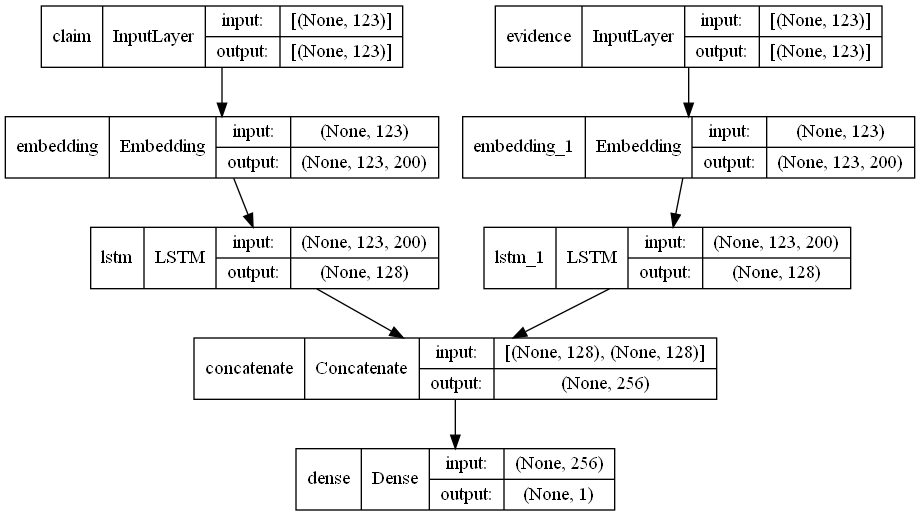

In [ ]:
# model 11: last state (output)
claim_input = keras.Input(shape = (max_seq_length,), name="claim") 
evidence_input = keras.Input(shape = (max_seq_length,), name="evidence") 

claim_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (claim_input)
evidence_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (evidence_input)

claim_features = layers.LSTM(s_embedding_dim) (claim_w_embeds)
evidence_features = layers.LSTM(s_embedding_dim) (evidence_w_embeds)

concat = layers.concatenate([claim_features, evidence_features])

output = layers.Dense(1, activation= 'sigmoid') (concat)

model_11 = create_model()

# display model architecture for first model only
keras.utils.plot_model(model_11, "model shape.png", show_shapes=True)

In [ ]:
#model 21: average output states
# s: sentence ; w: word ; embed: embeddings

claim_input = keras.Input(shape = (max_seq_length,), name="claim") 
evidence_input = keras.Input(shape = (max_seq_length,), name="evidence") 

claim_w_embed = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (claim_input)
evidence_w_embed = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (evidence_input)

claim_s_embed = layers.LSTM(s_embedding_dim, return_sequences=True) (claim_w_embed) #[batch_size, timesteps, output_size]
evidence_s_embed = layers.LSTM(s_embedding_dim,return_sequences=True) (evidence_w_embed)

claim_features = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1), name='average_c') (claim_s_embed)
evidence_features = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1), name='average_e') (evidence_s_embed)

concat = layers.concatenate([claim_features, evidence_features])

output = layers.Dense(1, activation= 'sigmoid') (concat)

model_21 = create_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 123)]        0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 123)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 123, 200)     7158000     ['claim[0][0]']                  
                                                                                                  
 embedding_3 (Embedding)        (None, 123, 200)     7158000     ['evidence[0][0]']               
                                                                                            

In [ ]:
# model 31: MLP
claim_input = keras.Input(shape = (max_seq_length,), name="claim") 
evidence_input = keras.Input(shape = (max_seq_length,), name="evidence") 

claim_w_embed = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (claim_input)
evidence_w_embed = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (evidence_input)

x1 = layers.Flatten() (claim_w_embed)
x2 = layers.Flatten() (evidence_w_embed)

claim_features = layers.Dense(s_embedding_dim) (x1)
evidence_features = layers.Dense(s_embedding_dim) (x2)

concat = layers.concatenate([claim_features, evidence_features])

output = layers.Dense(1, activation= 'sigmoid') (concat)

model_31 = create_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 123)]        0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 123)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 123, 200)     7158000     ['claim[0][0]']                  
                                                                                                  
 embedding_5 (Embedding)        (None, 123, 200)     7158000     ['evidence[0][0]']               
                                                                                            

In [ ]:
# model 41: BoV
claim_input = keras.Input(shape = (max_seq_length,), name="claim") 
evidence_input = keras.Input(shape = (max_seq_length,), name="evidence") 

claim_w_embed = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (claim_input)
evidence_w_embed = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (evidence_input)

claim_features = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1), name='average_c') (claim_w_embed)
evidence_features = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1), name='average_e') (evidence_w_embed)

concat = layers.concatenate([claim_features, evidence_features])

output = layers.Dense(1, activation= 'sigmoid') (concat)

model_41 = create_model()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 123)]        0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 123)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 123, 200)     7158000     ['claim[0][0]']                  
                                                                                                  
 embedding_7 (Embedding)        (None, 123, 200)     7158000     ['evidence[0][0]']               
                                                                                            

###Train

Epoch 1/10
119/119 [==============================] - 19s 80ms/step - loss: 0.4628 - accuracy: 0.7974 - val_loss: 0.5825 - val_accuracy: 0.7086
Epoch 2/10
119/119 [==============================] - 8s 64ms/step - loss: 0.3383 - accuracy: 0.8572 - val_loss: 0.5539 - val_accuracy: 0.7319
Epoch 3/10
119/119 [==============================] - 8s 64ms/step - loss: 0.2946 - accuracy: 0.8755 - val_loss: 0.5635 - val_accuracy: 0.7403
Epoch 4/10
119/119 [==============================] - 8s 64ms/step - loss: 0.2664 - accuracy: 0.8878 - val_loss: 0.6116 - val_accuracy: 0.7344
Epoch 5/10
119/119 [==============================] - 8s 65ms/step - loss: 0.2415 - accuracy: 0.8977 - val_loss: 0.6636 - val_accuracy: 0.7298
Displaying the following history keys:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


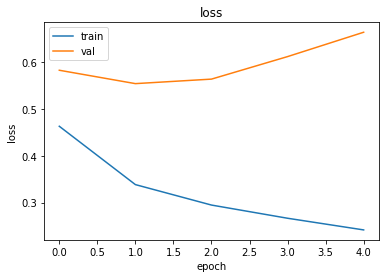

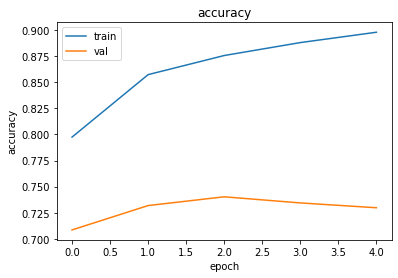

In [ ]:
history = model_11.fit(
    {"claim": x_train_c, "evidence": x_train_e},
    y = y_train,
    validation_data=((x_val_c, x_val_e), y_val),
    epochs=10,
    batch_size=1024,
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3,
                                                restore_best_weights=True)]
)
show_history(history)

Epoch 1/10
119/119 [==============================] - 16s 86ms/step - loss: 0.5712 - accuracy: 0.7332 - val_loss: 0.6903 - val_accuracy: 0.5297
Epoch 2/10
119/119 [==============================] - 8s 68ms/step - loss: 0.4688 - accuracy: 0.7925 - val_loss: 0.6450 - val_accuracy: 0.6597
Epoch 3/10
119/119 [==============================] - 8s 68ms/step - loss: 0.4125 - accuracy: 0.8292 - val_loss: 0.6663 - val_accuracy: 0.6706
Epoch 4/10
119/119 [==============================] - 8s 68ms/step - loss: 0.3792 - accuracy: 0.8428 - val_loss: 0.6380 - val_accuracy: 0.6826
Epoch 5/10
119/119 [==============================] - 8s 68ms/step - loss: 0.3540 - accuracy: 0.8536 - val_loss: 0.6727 - val_accuracy: 0.6860
Epoch 6/10
119/119 [==============================] - 8s 69ms/step - loss: 0.3333 - accuracy: 0.8626 - val_loss: 0.6447 - val_accuracy: 0.6948
Epoch 7/10
119/119 [==============================] - 8s 69ms/step - loss: 0.3160 - accuracy: 0.8696 - val_loss: 0.6817 - val_accuracy: 0.697

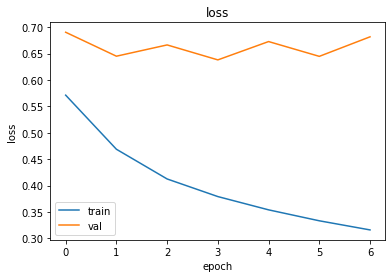

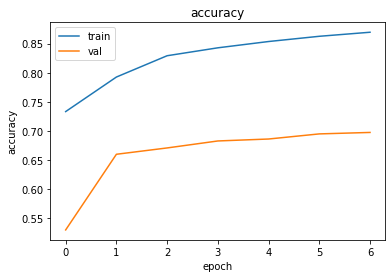

In [ ]:
history = model_21.fit(
    {"claim": x_train_c, "evidence": x_train_e},
    y = y_train,
    validation_data=((x_val_c, x_val_e), y_val),
    epochs=10,
    batch_size=1024,
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3,
                                                restore_best_weights=True)]
)
show_history(history)

Epoch 1/10
119/119 [==============================] - 4s 31ms/step - loss: 0.5339 - accuracy: 0.7782 - val_loss: 0.6293 - val_accuracy: 0.6826
Epoch 2/10
119/119 [==============================] - 4s 30ms/step - loss: 0.3424 - accuracy: 0.8548 - val_loss: 0.6126 - val_accuracy: 0.7114
Epoch 3/10
119/119 [==============================] - 4s 30ms/step - loss: 0.2853 - accuracy: 0.8809 - val_loss: 0.6982 - val_accuracy: 0.7101
Epoch 4/10
119/119 [==============================] - 4s 30ms/step - loss: 0.2410 - accuracy: 0.9012 - val_loss: 0.6961 - val_accuracy: 0.7209
Epoch 5/10
119/119 [==============================] - 4s 30ms/step - loss: 0.2103 - accuracy: 0.9142 - val_loss: 0.7499 - val_accuracy: 0.7181
Displaying the following history keys:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


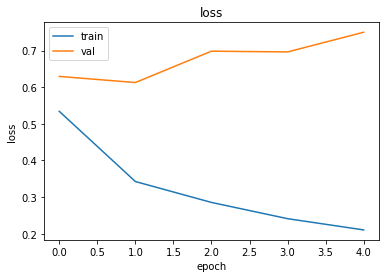

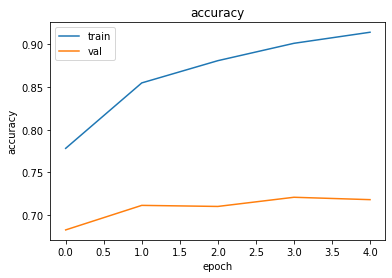

In [ ]:
history = model_31.fit(
    {"claim": x_train_c, "evidence": x_train_e},
    y = y_train,
    validation_data=((x_val_c, x_val_e), y_val),
    epochs=10,
    batch_size=1024,
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3,
                                                restore_best_weights=True)]
)
show_history(history)

Epoch 1/30
119/119 [==============================] - 3s 24ms/step - loss: 0.5893 - accuracy: 0.7333 - val_loss: 0.8105 - val_accuracy: 0.5040
Epoch 2/30
119/119 [==============================] - 3s 23ms/step - loss: 0.5730 - accuracy: 0.7343 - val_loss: 0.8008 - val_accuracy: 0.5040
Epoch 3/30
119/119 [==============================] - 3s 23ms/step - loss: 0.5642 - accuracy: 0.7343 - val_loss: 0.7792 - val_accuracy: 0.5040
Epoch 4/30
119/119 [==============================] - 3s 23ms/step - loss: 0.5485 - accuracy: 0.7343 - val_loss: 0.7643 - val_accuracy: 0.5043
Epoch 5/30
119/119 [==============================] - 3s 23ms/step - loss: 0.5252 - accuracy: 0.7366 - val_loss: 0.7546 - val_accuracy: 0.5100
Epoch 6/30
119/119 [==============================] - 3s 23ms/step - loss: 0.4978 - accuracy: 0.7529 - val_loss: 0.7134 - val_accuracy: 0.5475
Epoch 7/30
119/119 [==============================] - 3s 23ms/step - loss: 0.4720 - accuracy: 0.7768 - val_loss: 0.6866 - val_accuracy: 0.5853

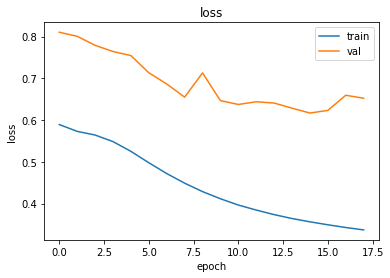

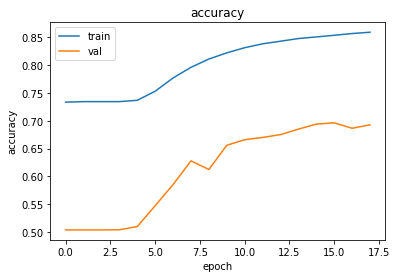

In [ ]:
history = model_41.fit(
    {"claim": x_train_c, "evidence": x_train_e},
    y = y_train,
    validation_data=((x_val_c, x_val_e), y_val),
    epochs=30,
    batch_size=1024,
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3,
                                                restore_best_weights=True)]
)
show_history(history)

###Results

| Model      | Val Accuracy |
| ----------- | :------:   |
| model_11      | 0.735      |
| model_21   | 0.679        |
| model_31      | 0.728      |
| model_41      | 0.699       |

model_11 outperformed the rest so we chose sentence embedding strategy 1 (RNN with last output as sentence embedding) for the rest of the experiments

##Merging Inputs strategies

In this section, we compare the input-merging strategies:
1. Concatenation (already tested in previous section)
2. Sum
3. Mean


###Compile

In [ ]:
# model 12: last state (output) + sum inputs
claim_input = keras.Input(shape = (max_seq_length,), name="claim") 
evidence_input = keras.Input(shape = (max_seq_length,), name="evidence") 

claim_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (claim_input)
evidence_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (evidence_input)

claim_features = layers.LSTM(s_embedding_dim) (claim_w_embeds)
evidence_features = layers.LSTM(s_embedding_dim) (evidence_w_embeds)

add = layers.Add() ([claim_features, evidence_features])

output = layers.Dense(1, activation= 'sigmoid') (add)

model_12 = create_model()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 123)]        0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 123)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 123, 200)     7158000     ['claim[0][0]']                  
                                                                                                  
 embedding_9 (Embedding)        (None, 123, 200)     7158000     ['evidence[0][0]']               
                                                                                            

In [ ]:
# model 13: last state (output) + mean of inputs
claim_input = keras.Input(shape = (max_seq_length,), name="claim") 
evidence_input = keras.Input(shape = (max_seq_length,), name="evidence") 

claim_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (claim_input)
evidence_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (evidence_input)

claim_features = layers.LSTM(s_embedding_dim) (claim_w_embeds)
evidence_features = layers.LSTM(s_embedding_dim) (evidence_w_embeds)

mean = layers.Average() ([claim_features, evidence_features])

output = layers.Dense(1, activation= 'sigmoid') (mean)

model_13 = create_model()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 123)]        0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 123)]        0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 123, 200)     7158000     ['claim[0][0]']                  
                                                                                                  
 embedding_11 (Embedding)       (None, 123, 200)     7158000     ['evidence[0][0]']               
                                                                                            

###Train

Epoch 1/10
119/119 [==============================] - 17s 87ms/step - loss: 0.4580 - accuracy: 0.7997 - val_loss: 0.5809 - val_accuracy: 0.7103
Epoch 2/10
119/119 [==============================] - 8s 68ms/step - loss: 0.3370 - accuracy: 0.8568 - val_loss: 0.5349 - val_accuracy: 0.7403
Epoch 3/10
119/119 [==============================] - 8s 68ms/step - loss: 0.2943 - accuracy: 0.8760 - val_loss: 0.5846 - val_accuracy: 0.7362
Epoch 4/10
119/119 [==============================] - 8s 68ms/step - loss: 0.2653 - accuracy: 0.8877 - val_loss: 0.6004 - val_accuracy: 0.7376
Epoch 5/10
119/119 [==============================] - 8s 71ms/step - loss: 0.2416 - accuracy: 0.8975 - val_loss: 0.6596 - val_accuracy: 0.7327
Displaying the following history keys:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


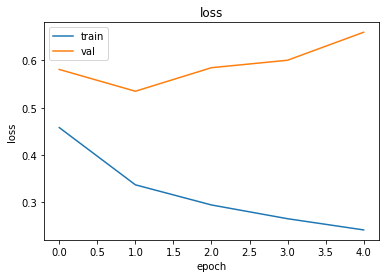

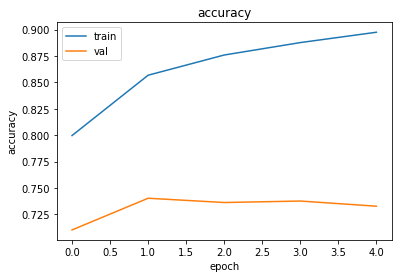

In [ ]:
history = model_12.fit(
    {"claim": x_train_c, "evidence": x_train_e},
    y = y_train,
    validation_data=((x_val_c, x_val_e), y_val),
    epochs=10,
    batch_size=1024,
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3,
                                                restore_best_weights=True)]
)
show_history(history)

Epoch 1/10
119/119 [==============================] - 17s 87ms/step - loss: 0.4719 - accuracy: 0.7923 - val_loss: 0.5924 - val_accuracy: 0.7093
Epoch 2/10
119/119 [==============================] - 8s 69ms/step - loss: 0.3413 - accuracy: 0.8562 - val_loss: 0.5442 - val_accuracy: 0.7358
Epoch 3/10
119/119 [==============================] - 8s 70ms/step - loss: 0.2977 - accuracy: 0.8745 - val_loss: 0.5703 - val_accuracy: 0.7436
Epoch 4/10
119/119 [==============================] - 8s 71ms/step - loss: 0.2688 - accuracy: 0.8868 - val_loss: 0.5985 - val_accuracy: 0.7383
Epoch 5/10
119/119 [==============================] - 9s 73ms/step - loss: 0.2460 - accuracy: 0.8968 - val_loss: 0.6332 - val_accuracy: 0.7333
Displaying the following history keys:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


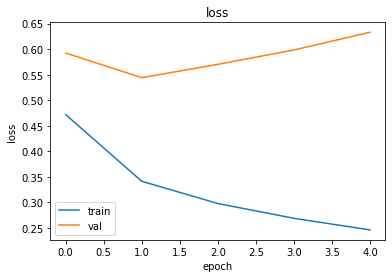

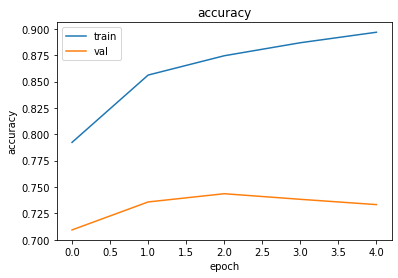

In [ ]:
history = model_13.fit(
    {"claim": x_train_c, "evidence": x_train_e},
    y = y_train,
    validation_data=((x_val_c, x_val_e), y_val),
    epochs=10,
    batch_size=1024,
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3,
                                                restore_best_weights=True)]
)
show_history(history)

###Results

| Model      | Val Accuracy |
| ----------- | :----:   |
| model_11   | 0.737    |
| model_12      | 0.735       |
| model_13   | 0.742      |

In this section, we tested the sum and the mean input merging strategies, and from the results we see that (which is better?)

##Cosine similarity extension

In this section we extend model_11, model_12 and model_13 with the cosine similarity metric as an additional feature to the input classification.

###Compile

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 123)]        0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 123)]        0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 123, 200)     7158000     ['claim[0][0]']                  
                                                                                                  
 embedding_13 (Embedding)       (None, 123, 200)     7158000     ['evidence[0][0]']               
                                                                                            

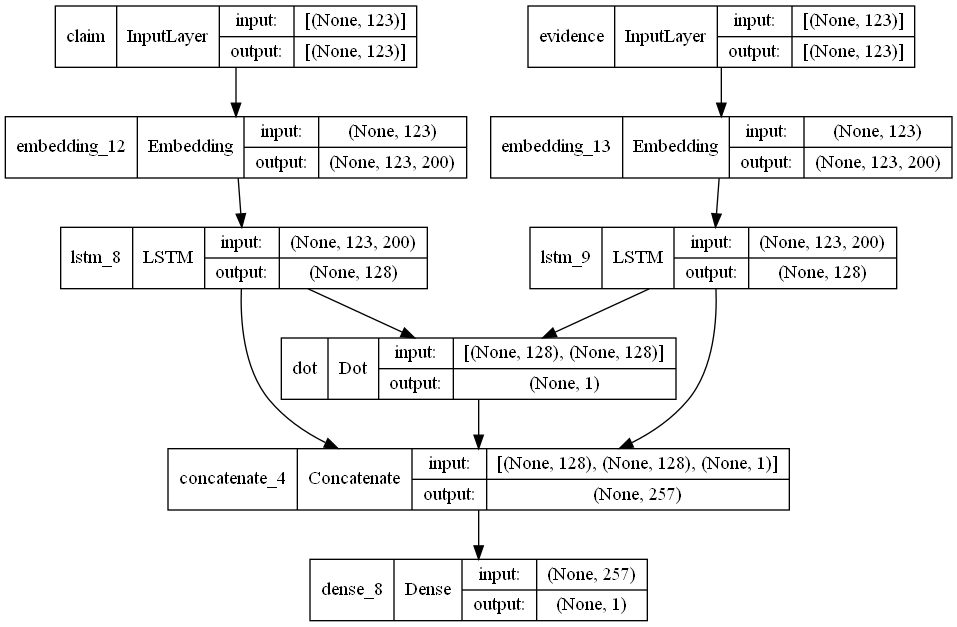

In [ ]:
# model_11 with extension
claim_input = keras.Input(shape = (max_seq_length,), name="claim") 
evidence_input = keras.Input(shape = (max_seq_length,), name="evidence") 

claim_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (claim_input)
evidence_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (evidence_input)

claim_features = layers.LSTM(s_embedding_dim,) (claim_w_embeds)
evidence_features = layers.LSTM(s_embedding_dim) (evidence_w_embeds)

cosine = tf.keras.layers.Dot(axes=1, normalize=True)([claim_features, evidence_features])

concat = layers.concatenate([claim_features, evidence_features, cosine])

output = layers.Dense(1, activation= 'sigmoid') (concat)

model_11x = create_model()

keras.utils.plot_model(model_11x, "model_11x.png", show_shapes=True)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 123)]        0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 123)]        0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 123, 200)     7158000     ['claim[0][0]']                  
                                                                                                  
 embedding_15 (Embedding)       (None, 123, 200)     7158000     ['evidence[0][0]']               
                                                                                            

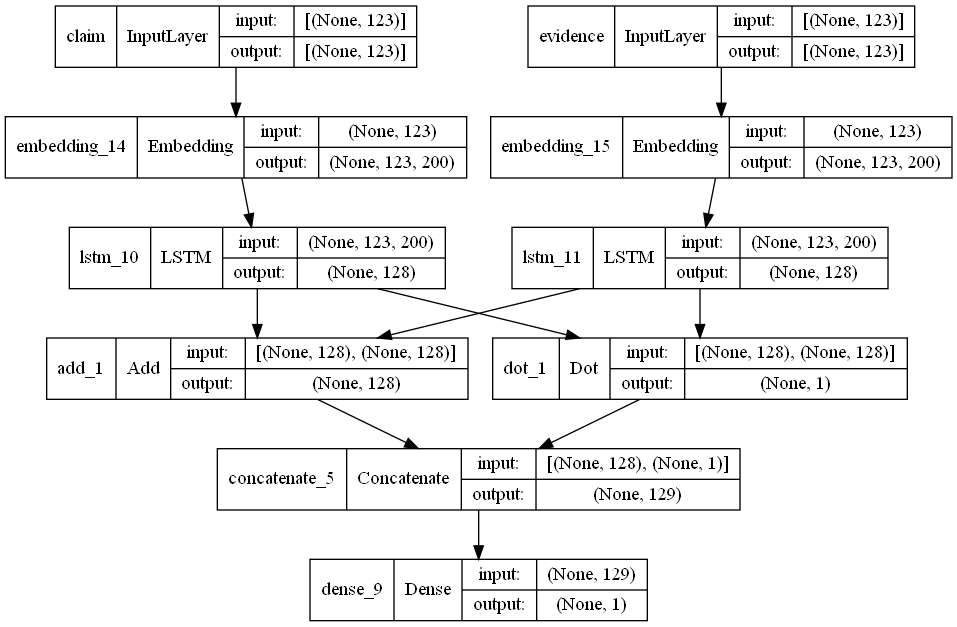

In [ ]:
# model_12 with extension
claim_input = keras.Input(shape = (max_seq_length,), name="claim") 
evidence_input = keras.Input(shape = (max_seq_length,), name="evidence") 

claim_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (claim_input)
evidence_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (evidence_input)

claim_features = layers.LSTM(s_embedding_dim) (claim_w_embeds)
evidence_features = layers.LSTM(s_embedding_dim) (evidence_w_embeds)

cosine = tf.keras.layers.Dot(axes=1, normalize=True)([claim_features, evidence_features])
add = layers.Add() ([claim_features, evidence_features])

concat = layers.concatenate([add, cosine])

output = layers.Dense(1, activation= 'sigmoid') (concat)

model_12x = create_model()

keras.utils.plot_model(model_12x, "model_12x.png", show_shapes=True)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 123)]        0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 123)]        0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 123, 200)     7158000     ['claim[0][0]']                  
                                                                                                  
 embedding_17 (Embedding)       (None, 123, 200)     7158000     ['evidence[0][0]']               
                                                                                            

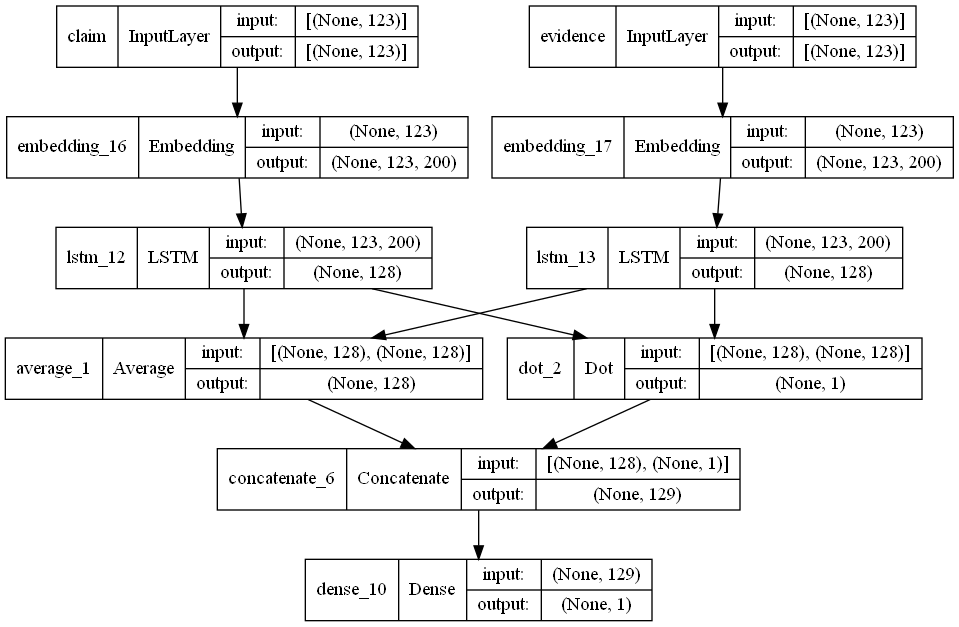

In [ ]:
# model_13 with extension
claim_input = keras.Input(shape = (max_seq_length,), name="claim") 
evidence_input = keras.Input(shape = (max_seq_length,), name="evidence") 

claim_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (claim_input)
evidence_w_embeds = layers.Embedding(vocab_size, w_embedding_dim, mask_zero=True) (evidence_input)

claim_features = layers.LSTM(s_embedding_dim) (claim_w_embeds)
evidence_features = layers.LSTM(s_embedding_dim) (evidence_w_embeds)

cosine = tf.keras.layers.Dot(axes=1, normalize=True)([claim_features, evidence_features])
mean = layers.Average() ([claim_features, evidence_features])

concat = layers.concatenate([mean, cosine])

output = layers.Dense(1, activation= 'sigmoid') (concat)

model_13x = create_model()

keras.utils.plot_model(model_13x, "model_13x.png", show_shapes=True)

###Train

Epoch 1/10
119/119 [==============================] - 17s 87ms/step - loss: 0.4640 - accuracy: 0.7967 - val_loss: 0.5977 - val_accuracy: 0.7059
Epoch 2/10
119/119 [==============================] - 8s 70ms/step - loss: 0.3385 - accuracy: 0.8565 - val_loss: 0.5758 - val_accuracy: 0.7306
Epoch 3/10
119/119 [==============================] - 9s 72ms/step - loss: 0.2942 - accuracy: 0.8760 - val_loss: 0.5822 - val_accuracy: 0.7371
Epoch 4/10
119/119 [==============================] - 9s 75ms/step - loss: 0.2644 - accuracy: 0.8878 - val_loss: 0.6244 - val_accuracy: 0.7311
Epoch 5/10
119/119 [==============================] - 9s 75ms/step - loss: 0.2397 - accuracy: 0.8980 - val_loss: 0.6415 - val_accuracy: 0.7340
Displaying the following history keys:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


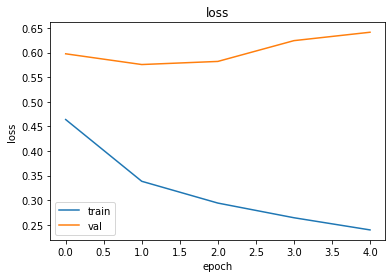

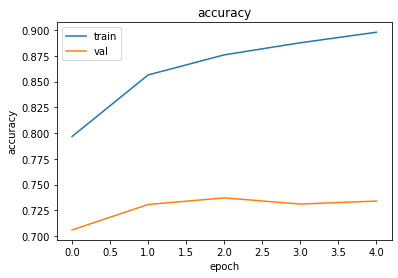

In [ ]:
history = model_11x.fit(
    {"claim": x_train_c, "evidence": x_train_e},
    y = y_train,
    validation_data=((x_val_c, x_val_e), y_val),
    epochs=10,
    batch_size=1024,
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3,
                                                restore_best_weights=True)]
)
show_history(history)

Epoch 1/10
119/119 [==============================] - 18s 92ms/step - loss: 0.4603 - accuracy: 0.7978 - val_loss: 0.5742 - val_accuracy: 0.7125
Epoch 2/10
119/119 [==============================] - 9s 73ms/step - loss: 0.3370 - accuracy: 0.8575 - val_loss: 0.5832 - val_accuracy: 0.7237
Epoch 3/10
119/119 [==============================] - 9s 76ms/step - loss: 0.2952 - accuracy: 0.8757 - val_loss: 0.5867 - val_accuracy: 0.7337
Epoch 4/10
119/119 [==============================] - 9s 76ms/step - loss: 0.2671 - accuracy: 0.8869 - val_loss: 0.6455 - val_accuracy: 0.7312
Displaying the following history keys:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


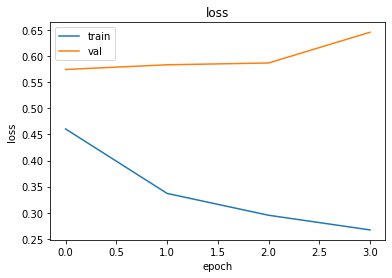

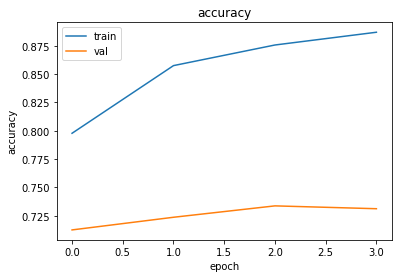

In [ ]:
history = model_12x.fit(
    {"claim": x_train_c, "evidence": x_train_e},
    y = y_train,
    validation_data=((x_val_c, x_val_e), y_val),
    epochs=10,
    batch_size=1024,
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3,
                                                restore_best_weights=True)]
)
show_history(history)

Epoch 1/10
119/119 [==============================] - 18s 94ms/step - loss: 0.4795 - accuracy: 0.7907 - val_loss: 0.5780 - val_accuracy: 0.7069
Epoch 2/10
119/119 [==============================] - 9s 73ms/step - loss: 0.3474 - accuracy: 0.8530 - val_loss: 0.5600 - val_accuracy: 0.7285
Epoch 3/10
119/119 [==============================] - 9s 76ms/step - loss: 0.3001 - accuracy: 0.8738 - val_loss: 0.5884 - val_accuracy: 0.7350
Epoch 4/10
119/119 [==============================] - 9s 76ms/step - loss: 0.2686 - accuracy: 0.8869 - val_loss: 0.6087 - val_accuracy: 0.7316
Epoch 5/10
119/119 [==============================] - 9s 78ms/step - loss: 0.2448 - accuracy: 0.8969 - val_loss: 0.6429 - val_accuracy: 0.7347
Displaying the following history keys:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


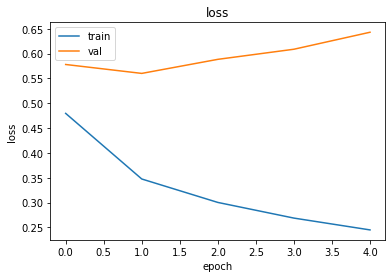

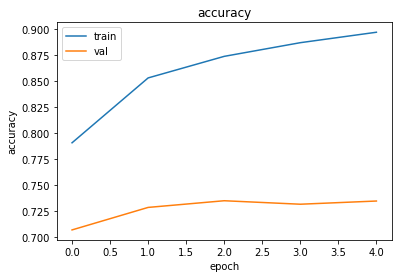

In [ ]:
history = model_13x.fit(
    {"claim": x_train_c, "evidence": x_train_e},
    y = y_train,
    validation_data=((x_val_c, x_val_e), y_val),
    epochs=10,
    batch_size=1024,
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3,
                                                restore_best_weights=True)]
)
show_history(history)

###Results

| Model      | Val Accuracy |   
| ----------- | :----:   |
| model_11x   | 0.741    |
| model_12x      | 0.741 |
| model_13x   | 0.738    |

| Model      | Val Accuracy |
| ----------- | :----:   |
| model_11   | 0.737    |
| model_12      | 0.735       |
| model_13   | 0.742      |

As we can see from the results, the cosine similarity extension had a small positive (0.4% for 11x and 0.6% for 12x) or negative effect (-0.4%) on the validation accuracy of the model.

Since model_11x, model_12x and model_13 achieved very similar validation results we decided to evaluate all of them on the test set.

#lll- Evaluation

##Evaluation setup

For the 2nd evaluation method, in order to evaluate a claim prediction based on all of its evidence sentences, we need 2 new arrays:
* **unique_predicitons**: claim-specific predictions that aggregate the classification results for each claim by majority voting 
* **y_test_unique**: claim-specific true labels.

We create **y_test_unique** by removing rows with duplicate IDs in the test split which is straightforward. These will be the claim-specific true labels.

For the **unique_predicitons**, it is a bit more complicated since the model is unaware of the ID of each prediction. 
To solve this, we initialize a dictionary Votes where for each id in the test split, Votes[id] = (id, votes=0). 
To fill it, we accumulate for each ID the number of supporting and refuting predictions from the model predictions. This process is described below. 

For each model prediction:

1. we fetch its claim ID from the duplicates-free test dataframe based on index
2. if label is 1 --> increment corresponding value in Votes, 0 --> decrement

Then, we need to 
then for each ID in the dictionary:

* if #votes > 0: y = 1
* if #votes = 0: y = random value of 0 or 1, since they are too few (<0.3% of result)
* if #votes < 0: y = 0

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay


def unique_x_y(predictions: np.ndarray):
    """
    Generates claim-specific predictions and labels to use in the
    majority voting evaluation type

    :param predictions: rounded model predictions in np.ndarray format

    :return
        unique_x: predictions based on majority voting
        unique_y: claim-specific labels
    """

    # extract test split and reset index
    global test_df
    test_df = dfc.loc[dfc['split']=='test'].reset_index(drop=True)

    # initialize dictionary of (id, votes) pairs
    global Votes
    Votes = {}
    for id in test_df['ID']:
        if id not in Votes: Votes[id] = 0

    # fill dict votes by implementing majority voting
    for i in range(len(predictions)):
        id = test_df.iat[i, 2]
        if predictions[i] == 1:
            Votes[id] += 1
        else: 
            Votes[id] -=1

    # create unique_y by dropping duplicates from test split
    df_unique_ids = test_df.drop_duplicates('ID')
    unique_y = df_unique_ids['Label'].values

    # create unique_x based on votes from dict Votes
    unique_x = np.zeros((len(unique_y),), dtype=np.uint8)

    for i in range(len(unique_x)):
        id = df_unique_ids.iat[i,2]
        if  Votes[id] > 0: 
            unique_x[i] = 1 
        elif Votes[id] == 0: 
            unique_x[i] = np.random.randint(0, 2, dtype=np.uint8)

    assert(len(unique_x) == len(unique_y))

    return unique_x, unique_y

def evaluate_predictions(predictions: np.ndarray,
                         y: np.ndarray,
                         metrics: List[Callable],
                         metric_names: List[str]):
    """
    Evaluates given model predictions on a list of metric functions

    :param predictions: model predictions in np.ndarray format
    :param y: ground-truth labels in np.ndarray format
    :param metrics: list of metric functions
    :param metric_names: list of metric names

    :return
        metric_info: dictionary containing metric values for each input metric
    """

    assert len(metrics) == len(metric_names)

    print("Total samples: ", y.shape[0])

    metric_info = {}

    for metric, metric_name in zip(metrics, metric_names):
        metric_value = metric(y_pred=predictions, y_true=y)
        metric_info[metric_name] = metric_value

    return metric_info

def evaluate(predictions: np.ndarray,
             y: np.ndarray):
    """
    Displays confusion matrix and evaluation metrics

    :param predictions: rounded model predictions in np.ndarray format
    :param y: ground-truth labels in np.ndarray format
    """

    metrics = [
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
    ]
    metric_names = [
        "accuracy",
        'precision',
        'recall',
        "f1"
    ]

    metric_info = evaluate_predictions(predictions=predictions,
                                       y=y,
                                       metrics=metrics,
                                       metric_names=metric_names)
    print('Metrics info: \n{}'.format(metric_info))
    print()

    report = classification_report(y, predictions)
    print(report)

##Inference

###Model 13

In [ ]:
# predict and evaluate model 13

predictions = model_13.predict( {"claim": x_test_c, "evidence": x_test_e})
predictions = predictions.round()
unique_predictions, unique_labels = unique_x_y(predictions)

print('Evaluation type 1:\n')
evaluate(predictions, y_test)
print()

print('Evaluation type 2:\n')
evaluate(unique_predictions, unique_labels)

Evaluation type 1:

Total samples:  7189
Metrics info: 
{'accuracy': 0.7188760606482125, 'precision': 0.6613067372277631, 'recall': 0.9009983361064892, 'f1': 0.7627655828148844}

              precision    recall  f1-score   support

           0       0.84      0.54      0.66      3583
           1       0.66      0.90      0.76      3606

    accuracy                           0.72      7189
   macro avg       0.75      0.72      0.71      7189
weighted avg       0.75      0.72      0.71      7189


Evaluation type 2:

Total samples:  6613
Metrics info: 
{'accuracy': 0.7181309541811584, 'precision': 0.6601640434493461, 'recall': 0.8999697793895437, 'f1': 0.7616368286445012}

              precision    recall  f1-score   support

           0       0.84      0.54      0.66      3304
           1       0.66      0.90      0.76      3309

    accuracy                           0.72      6613
   macro avg       0.75      0.72      0.71      6613
weighted avg       0.75      0.72      0.7

###Models 11x, 12x

In [ ]:
# predict and evaluate model 11x

predictions = model_11x.predict( {"claim": x_test_c, "evidence": x_test_e})
predictions = predictions.round()
unique_predictions, unique_labels = unique_x_y(predictions)

print('Evaluation type 1:\n')
evaluate(predictions, y_test)
print()

print('Evaluation type 2:\n')
evaluate(unique_predictions, unique_labels)

Evaluation type 1:

Total samples:  7189
Metrics info: 
{'accuracy': 0.7113645847823064, 'precision': 0.6537457320747138, 'recall': 0.9026622296173045, 'f1': 0.7582993593476995}

              precision    recall  f1-score   support

           0       0.84      0.52      0.64      3583
           1       0.65      0.90      0.76      3606

    accuracy                           0.71      7189
   macro avg       0.75      0.71      0.70      7189
weighted avg       0.75      0.71      0.70      7189


Evaluation type 2:

Total samples:  6613
Metrics info: 
{'accuracy': 0.7107213065174656, 'precision': 0.6527352297592998, 'recall': 0.9014808099123602, 'f1': 0.7572026906967888}

              precision    recall  f1-score   support

           0       0.84      0.52      0.64      3304
           1       0.65      0.90      0.76      3309

    accuracy                           0.71      6613
   macro avg       0.75      0.71      0.70      6613
weighted avg       0.75      0.71      0.7

In [ ]:
# predict and evaluate model 12x

predictions = model_12x.predict( {"claim": x_test_c, "evidence": x_test_e})
predictions = predictions.round()
unique_predictions, unique_labels = unique_x_y(predictions)

print('Evaluation type 1:\n')
evaluate(predictions, y_test)
print()

print('Evaluation type 2:\n')
evaluate(unique_predictions, unique_labels)

Evaluation type 1:

Total samples:  7189
Metrics info: 
{'accuracy': 0.699401863958826, 'precision': 0.6364494806421152, 'recall': 0.9345535219079312, 'f1': 0.7572182900797663}

              precision    recall  f1-score   support

           0       0.88      0.46      0.61      3583
           1       0.64      0.93      0.76      3606

    accuracy                           0.70      7189
   macro avg       0.76      0.70      0.68      7189
weighted avg       0.76      0.70      0.68      7189


Evaluation type 2:

Total samples:  6613
Metrics info: 
{'accuracy': 0.6986239225767428, 'precision': 0.6352796052631579, 'recall': 0.9338168631006346, 'f1': 0.7561482931604062}

              precision    recall  f1-score   support

           0       0.87      0.46      0.61      3304
           1       0.64      0.93      0.76      3309

    accuracy                           0.70      6613
   macro avg       0.76      0.70      0.68      6613
weighted avg       0.75      0.70      0.68

#Test Results

| Model      | F1 score |   
| ----------- | :----:   |
| model_13   | 0.762    |
| model_11x      | 0.758 |
| model_12x   | 0.757    |

From the results we see that the F1 score was consistenlty better in all models for the SUPPORT class than for the REFUTE class, and that may be due to the class imbalance in the training set that favours the SUPPORT class.

Moreover, while 8.7% of the claims had multiple evidences, given by

```(total nb of test claims - nb of duplicate test claims) / total nb of test claims```

the results barely varied between the 1st and 2nd evaluation type (w/o vs with majority voting), precisely by a maximum of 0.3%

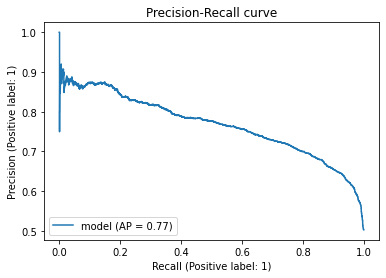

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
predictions = model_31.predict( {"claim": x_test_c, "evidence": x_test_e})
display = PrecisionRecallDisplay.from_predictions(y_test, predictions, name="model")
_ = display.ax_.set_title("Precision-Recall curve")
del display